In [1]:
# If needed, install huggingface libraries. You might have done this already.
!pip install transformers datasets

import pandas as pd
import numpy as np
import torch

# HuggingFace Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

# HuggingFace Datasets library
from datasets import Dataset


In [2]:
# Example: we pick Client 1's text data
CSV_PATH = "../data/processed/text/client_2_text.csv"

df = pd.read_csv(CSV_PATH)
print("Loaded text dataset shape:", df.shape)
df.head()


Loaded text dataset shape: (3126, 2)


,text,label
0,=?utf-8?b?tmv0zmxpecbbbgvyddpqbgvhc2ugq29uzmly...,1
1,=?utf-8?b?ww91cibhy2nvdw50ighhcybizwvuielpbwl0...,1
2,re: [uai] is it a paradox? (with an epistemic ...,0
3,your account is on hold your account is on hol...,1
4,from webmail admin! you have exceeded the stor...,1


In [3]:
# Convert the Pandas DataFrame to a HuggingFace Dataset
dataset = Dataset.from_pandas(df)
dataset


Dataset({
    features: ['text', 'label'],
    num_rows: 3126
})

In [4]:
MODEL_NAME = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [5]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/3126 [00:00<?, ? examples/s]

In [6]:
# Remove the original 'text' column
# Rename 'label' → 'labels' if needed
cols_to_remove = ["text", "__index_level_0__"]  # might vary
for col in cols_to_remove:
    if col in tokenized_dataset.column_names:
        tokenized_dataset = tokenized_dataset.remove_columns(col)

# If 'label' is present, rename to 'labels'
if "label" in tokenized_dataset.column_names:
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

tokenized_dataset.set_format("torch")
tokenized_dataset


Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3126
})

In [9]:
from pprint import pprint

for i in range(3):
    print(f"\n--- Sample {i} ---")
    pprint(tokenized_dataset[i])



--- Sample 0 ---
{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 'input_ids': tensor([  101,  1027,  1029, 21183,  2546,  1011,  1022,  1029,  1038,  1029,
         1056,  2213,  2615,  2692,  2480, 22984,  5051, 27421, 10322,  2290,
        10736, 14141,  2361,  4160,  2497,  2290,  2615, 16257,  2475, 15916,
         4160, 24594, 17040, 19968,  2100,  5910,  2497,  2480,  2497,  2509,
        10736, 10128,  3406,  2480,  2595, 10867,  2497, 23296,  2549,  2595,
        19022,  4160, 27487,  2683,  2863,  2860,  2595,  3363,  2290,  1027,
         1027,  1029,  1027,  6203,  8013, 2090

In [10]:
dataset_dict = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)
train_dataset = dataset_dict["train"]
val_dataset = dataset_dict["test"]

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))


Train size: 2500
Validation size: 626


In [11]:
from transformers import AutoModelForSequenceClassification

MODEL_NAME = "huawei-noah/TinyBERT_General_4L_312D"  # or your chosen TinyBERT
num_labels = 2  # phishing vs. legit

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments, Trainer
import numpy as np

training_args = TrainingArguments(
    output_dir="./tinybert_output_client1",
    eval_strategy="epoch",  # ← use eval_strategy instead
    save_strategy="epoch",
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)



In [13]:
#############################################
# 2. Define your metric (accuracy here)
#############################################
import numpy as np
from evaluate import load as load_metric

metric_accuracy = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_accuracy.compute(predictions=preds, references=labels)["accuracy"]
    return {"accuracy": acc}

In [14]:
#############################################
# 3. Create the Trainer
#############################################
trainer = Trainer(
    model=model,
    args=training_args,         # The TrainingArguments cell you made
    train_dataset=train_dataset, # from your splitted dataset
    eval_dataset=val_dataset,   # from your splitted dataset
    compute_metrics=compute_metrics,
)
print("Trainer object created.")

Trainer object created.


In [15]:
#############################################
# 4. Train the model
#############################################
trainer.train()
print("Training complete.")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.119612,0.974441
2,0.142400,0.103905,0.980831
3,0.142400,0.086518,0.984026


Training complete.


In [18]:
#############################################
# 5. Evaluate final performance
#############################################
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)



Evaluation results: {'eval_loss': 0.08651762455701828, 'eval_accuracy': 0.9840255591054313, 'eval_runtime': 2.3775, 'eval_samples_per_second': 263.307, 'eval_steps_per_second': 33.229, 'epoch': 3.0}


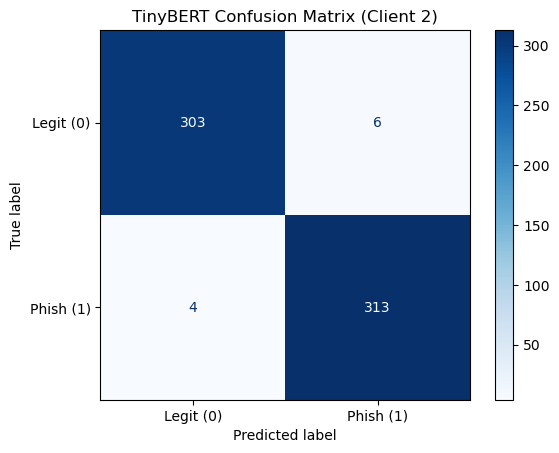

In [30]:
#############################################
# 6. (Optional) Confusion Matrix
#############################################
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Legit (0)", "Phish (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("TinyBERT Confusion Matrix (Client 2)")
plt.show()


In [20]:
final_metrics = trainer.evaluate()
print("Final Validation:", final_metrics)


Final Validation: {'eval_loss': 0.08651762455701828, 'eval_accuracy': 0.9840255591054313, 'eval_runtime': 1.9397, 'eval_samples_per_second': 322.728, 'eval_steps_per_second': 40.728, 'epoch': 3.0}


In [21]:
trainer.log_metrics("train", final_metrics)  # or any dict of metrics
trainer.save_metrics("train", final_metrics)


***** train metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.984
  eval_loss               =     0.0865
  eval_runtime            = 0:00:01.93
  eval_samples_per_second =    322.728
  eval_steps_per_second   =     40.728


In [22]:
from sklearn.metrics import classification_report

preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

print(classification_report(labels, preds, target_names=["Legit(0)", "Phish(1)"]))


              precision    recall  f1-score   support

    Legit(0)       0.99      0.98      0.98       309
    Phish(1)       0.98      0.99      0.98       317

    accuracy                           0.98       626
   macro avg       0.98      0.98      0.98       626
weighted avg       0.98      0.98      0.98       626



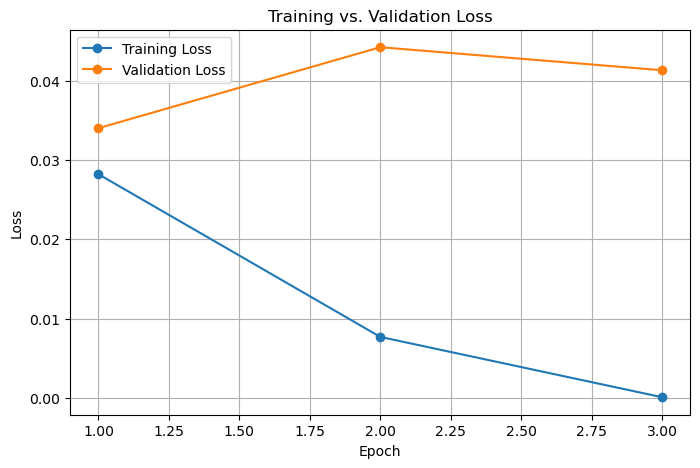

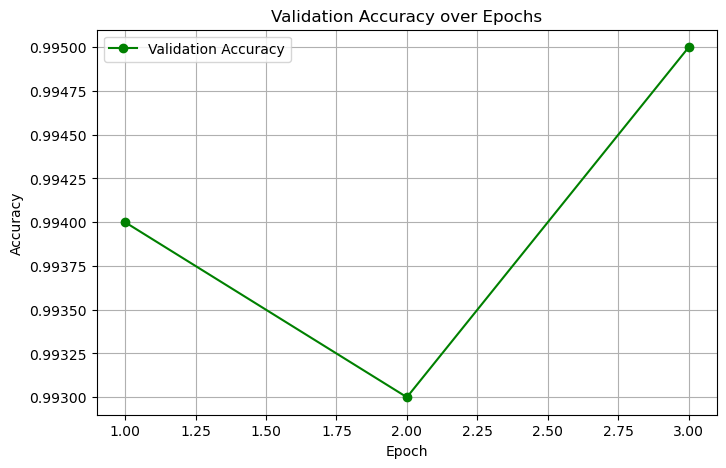

In [23]:
import matplotlib.pyplot as plt

# Replace with your actual data
train_losses = [0.0282, 0.0077, 0.0001]
val_losses = [0.0340, 0.0442, 0.0413]
val_accuracies = [0.994, 0.993, 0.995]
epochs = [1, 2, 3]

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()


In [24]:
# Run predictions using the Trainer
predictions = trainer.predict(val_dataset)

In [25]:
# Extract prediction probabilities and true labels
y_probs = predictions.predictions[:, 1]    # Probability for class 1 (phishing)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


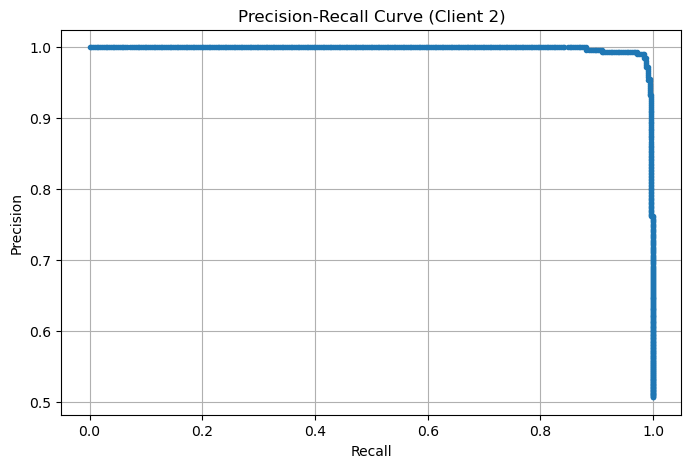

In [28]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Client 2)")
plt.grid(True)
plt.show()


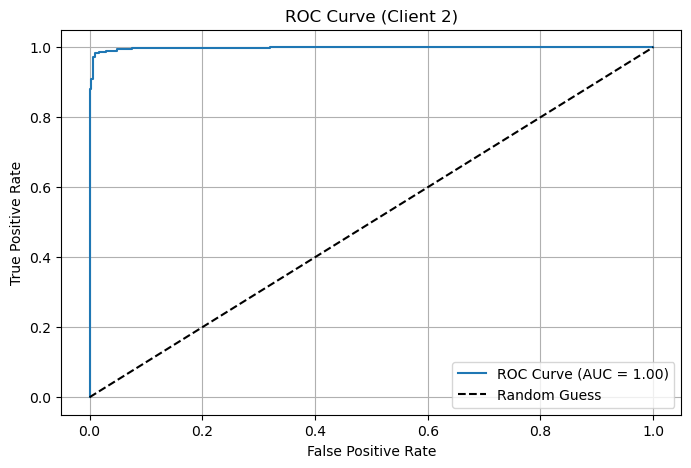

In [29]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Client 2)")
plt.legend()
plt.grid(True)
plt.show()
